# **Analysis of the public transport network of Zurich, Switzerland**

# 1. Introduction

The main goal of our project is to explore the resistance e.g. robustness of Zurichs public transport network based on a graph database of the public transportation dataset of the city of Zurich (Open Data Zürich - Stadt Zürich (stadt-zuerich.ch).

https://data.stadt-zuerich.ch/dataset/vbz_fahrzeiten_ogd_2018

The base dataset contains the bus and tram transport data for a whole week in the city of Zurich. Various variables are present under which the line number, travel direction, time of arrival at a stop, vehicle number, stop description and so on. The data comes in three different files in a csv format (Haltestelle.csv, Haltepunkt.csv, Fahrzeiten_SOLL_IST_20181230_20190105.csv).

In order to test the networks resistance we will first create a graph data base that displays the network structure of Zurichs transport network. Second, we will mimick "attacks" to the transport network. These attacks take the form of node removal from the network, that is we will subsequently delete random nodes and investigate the effects of these attacks. 



# 2. Creation of a graph database based on Zurich transport network in Neo4j 



The following steps were performed in order to create a graph database based on the raw data: 


1) 

2) 

The number of nodes is: 
The number of edges is: 


**Export:**
We opted for a `.graphml` format which was supported by _Neo4j_ as well as igraph to export and import the graph data. 


---

**Left:** The nodes of Zurich's transportation network          

**Right:** Visualization of shortest paths during node removal. 


<img src="https://drive.google.com/uc?export=view&id=1RGFndBLdCSWzOzkr6nYDz3Ue1GK_SQwn" style="display=block" width="500" height="400" align="left"/>

<img src="https://drive.google.com/uc?export=view&id=1ex1yEeg_70lDT7igwEbPYj-Ma-oWedBm" style="display=block" width="500" height="400" align="right"/>


# 3. Analysis of the Zurich transport network


## 3.1 Targeted deletion

To mimick a hostile attack, we will look at targeted deletion, e.g. when critical (in our case more important) nodes of the network are deleted. 
Node deletion is used to test the robustness and tolerance (of attacks) in networks. It is expected that the absence of any node in general increases the distance between the other nodes in the network, as paths are removed which previously contributed to the interconnection of the system.This is corresponding to an outage of a certain substop within the transport network. As a consequence, alternative routes have to be found to continue the traverse to destination. 

Similar to Albert et al. (2000) we will eliminate a node based on its criticality to the network and - after that - evaluate the effect of the limination on shortest paths and our measures. Like Holme et al. (2002), we will recalculate the centrality (e.g. betweenness) of the nodes after prior removal of other nodes. 

To address the tolerance of the network and the effects of node removal we study the changes in shortest path, modularity and betweenness when a node at a time is removed in function of its centrality in the network (targeted removal). 



## 3.2 Definition of cruciality 

Criticality of nodes depends on the point of view - we are interested in the most crucial lines for a majority of passengers and hence flow. In the remainder we will focus on the betweenness centrality. Degree and betweenness are found to be frequent measures (Scott et al. 2006, von Ferber et al., 2009). The betweenness centrality based attacks have been found to be more efficient than attacks based on selection of nodes based on degree centrality (Nie et al. 2015). 
Consequently, in the remainder we will be focusing on basing our attack on network on these nodes that are most critical as defined by their betweenness centrality calculation. 

The analysis is carried out by iteratively removing the node with the highest **betweenness centrality**. At each iteration the following metrics are computed: communities with Leiden algorithm, shortest paths between pairs of selected nodes, modularity and betweenness measures.

However, it also makes sense to look at **EigenCentrality**, since this measure of centrality takes the nodes importance across the whole network into account. 


Our approach is as follows: 


## 3.3 Evaluation of effects of node removal/ "attacks"

We will analyze the effects of node removal measuring the following metrics before and after each node removal: 

### 3.3.1 Shortest Paths
**The shortest paths** are computed between pairs of randomly selected nodes.
The shortest paths are computed as follows: initially, more frequented subpaths would receive a s**maller (?) weight**, given that they are of higher importance. We assume right now that: to get the shortest paths, the method tries to minimize weights, so we chose to invert the frequency based weights.
As a result, the calculation of shortest paths is influenced by the weights given.

### 3.3.2 Modularity
**Modularity** measures the strength of division of a network into clusters or communities. Hence, networks with high modularity are expected to have dense connections between the nodes within clusters but sparse connections between nodes in different clusters. Modularity helps to detect community structure in networks.

**Modularity calculation with the Leiden algorithm:**

We implemented the Leiden algorithmus for community detection. The Leiden algorithmus attempts to solve the shortcomings of the Louvain algorithm, and  yields communities that are guaranteed to be connected. Finally, the Leiden algorithm’s property is considered the newer and faster algorithm, it works only on neighborhoods that have recently been changed and speeds up computation by doing so. The Leiden algorithm allows for greater depth in choosing communities. When the Leiden algorithm is applied iteratively, it converges to a partition in which all subsets of all communities are locally connected. 

### 3.3.3 Edge Weights

 tbd


## 3.4 Implemented Functions

#### Package imports

In [224]:
!pip install neo4j
!pip install python-igraph
!pip install easygui
!pip install cairocffi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [225]:
from neo4j import GraphDatabase
import igraph as ig
from skimage.io import imread
import glob
import seaborn as sns 
import matplotlib.pyplot as plt 
import os
import pandas as pd
import warnings
import random
import numpy as np
import random 
import itertools 
from itertools import chain
warnings.filterwarnings("ignore")

In [226]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#### Graph saving and Visualization

In [227]:
def generate_graph(graph, modules, iteration=None, delete_previous_plots=True, layout='auto'):
  if not os.path.exists('clusters/'):
    os.mkdir('clusters/')
    
  if delete_previous_plots and iteration==1:
    for c in glob.glob('clusters/cluster*png'):
      os.remove(c)

  layout_gr = graph.layout(layout)

  colors =np.random.permutation(sns.color_palette("hls", len(modules))).tolist()
  #colors = sns.color_palette("hls", k)
  graph.vs['color'] = [None]
  for clid, cluster in enumerate(modules):
      for member in cluster:
          graph.vs[member]['color'] = colors[clid]

  visual_style = {}
  visual_style["vertex_size"] = 5
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (300, 300)
  pl = ig.plot(graph, **visual_style)
  if iteration:
    pl.save('clusters/clusters_{}_iter{}.png'.format(len(modules), iteration))
  else:
    pl.save('clusters/clusters_{}.png'.format(len(modules)))
  #return pl

def plot_graphs(img_path='clusters/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'cluster*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][4:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//4 + 1
    cols = len(img_list)//2
  else:
    rows = len(img_list)//4
    cols = len(img_list)//2

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'iteration ' + imf.split('_')[-1][4:-4] + '\n' +'n_clusters: ' + imf.split('_')[1] 
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

In [228]:
def shortest_path_graph(graph, gspaths, iteration, delete_previous_plots=True):
  """
  graph: current subgraph or main graph 
  gspaths: all the graph shortest paths being monitored at the current iteration
  """
  if not os.path.exists('shortest_paths/'):
    os.mkdir('shortest_paths/')

  if delete_previous_plots and iteration==1:
    for c in glob.glob('shortest_paths/spaths*png'):
      os.remove(c)

  # set default layout properties
  layout_gr = graph.layout('drl')
  colors =sns.color_palette("hls", len(gspaths))
  graph.vs['color'] = ['black']
  graph.vs['size'] = 2

  i = 0

  # iterate over all the node pairs for which the shortest path are computed at each iteration 
  for spaths in gspaths:
        # pick paths related to one pair of node in the list
        paths = gspaths[spaths]
        # each pair might contain more than one shortest path (not sure why...but it returns a list)
        for path in paths:
          # assign properties to highlight all the paths associated to the analysed pair of nodes. 
          for n in path:
            graph.vs[n]['color'] = colors[i]
            graph.vs[n]['size'] = 10
        i+=1
  visual_style = {}
  visual_style["vertex_size"] = graph.vs['size']
  visual_style["vertex_label"]=None
  visual_style["vertex_color"] = graph.vs['color']
  visual_style["layout"] = layout_gr
  visual_style["edge_width"] = 1
  visual_style["bbox"] = (400, 400)
  pl = ig.plot(graph, **visual_style)
  pl.save('shortest_paths/spaths_iteration_{}.png'.format(iteration))

def plot_shortest_paths(img_path='shortest_paths/', plot_limit=20, sample=False):
  i = 1
  # retrieve image fileanmes and sort them accordingly to iteration
  img_list = glob.glob(os.path.join(img_path,'spaths*.png'))

  # sample images or pick the first 0 to plot_limit ones
  if sample and len(img_list) > plot_limit:
    img_list = random.sample(img_list, plot_limit)
  else:
    img_list = img_list[:plot_limit]

  img_list.sort(key = lambda x: int(x.split('_')[-1][:-4]))
  
  # set subplot dimensions
  if len(img_list)%2!=0:
    rows = len(img_list)//4 + 1
    cols = len(img_list)//2
  else:
    rows = len(img_list)//4
    cols = len(img_list)//2

  if rows==0 and cols==0:
    rows = 1
    cols=1
  elif rows == 0:
    rows=1

  for imf in img_list:
      im = imread(imf)
      plt.subplot(rows,cols,i)
      plt.imshow(im)
      t = 'shortest paths' + '\n' + 'iteration ' + imf.split('_')[-1][:-4]
      plt.title(t, fontsize=15)
      plt.xticks([])
      plt.yticks([])
      i += 1

#### Network initialization

In [229]:
def normalize_weights(graph):
  # invers network weights
  for e in graph.es:
    e["weight"] /= max(graph.es["weight"])
  return graph

In [230]:
def init_network(graph):
  # convert network to undirected in order to perform the Louvain/Leiden algorithm
  # also invert weights to allow the shortest path picking up the most frequent routes
  graph_undirected = graph.copy()
  graph_undirected.to_undirected(combine_edges=dict(weight="sum"))
  graph_undirected = normalize_weights(graph_undirected)
  return graph_undirected

#### Graph Analysis

In [231]:
def get_most_central_node(subgraph, ref_ids=[], method='bwt'):
  # ref ids are the list of nodes that we do not want to remove from our graphs because they 
  # represent the nodes between which we want to compute the shortest paths
  if method=='btw':
    betw = subgraph.betweenness(weights=subgraph.es["weight"], directed=False)
    vind = np.argmax(betw)
    vid = subgraph.vs[vind]['id']

    # we keep on selecting the node to be removed as long as the one picked is one of the reference nodes 
    # we took as reference for the shortest path computation
    while vind in ref_ids:
      betw[np.argmax(betw)] = 0
      #print('node {} in {}'.format(vind, ref_ids))
      vind = np.argmax(betw)
      vid = subgraph.vs[vind]['id']

  elif method=='eig_cent':
    cent = subgraph.eigenvector_centrality()
    vind = np.argmax(cent)
    vid = subgraph.vs[vind]['id']
    while vind in ref_ids:
      cent[np.argmax(cent)] = 0
      vind = np.argmax(cent)
      vid = subgraph.vs[vind]['id']
  return vind, vid

In [232]:
def compute_spath_weight(graph, target_spaths):
  # this function takes the graph and the pre-computed shortest paths for a given list of reference points and returns a 
  # dictionary containing for each of them the total weight of their shortest path
  spath_weights = {}
  for targetpath in target_spaths:
    spaths=target_spaths[targetpath]
    pathweight=0
    for l in range(len(spaths[0])-1):
      eid = graph.get_eid(spaths[0][l], spaths[0][l+1], directed=False)
      pathweight += 1 - graph.es[eid]["weight"]
    spath_weights[targetpath] = pathweight
  return spath_weights

In [233]:
def get_spaths_node_ids(graph, target_spaths):
  # this function takes the graph and the pre-computed shortest paths for a given list of reference points and 
  # and convert the nodes indexes in the shortest path to node ids
  spath_ids = {}
  for targetpath in target_spaths:
    spaths=target_spaths[targetpath]
    spath_ids[targetpath] = [graph.vs[n]['id'] for n in spaths[0]]
  return spath_ids

In [246]:
def retrieve_internal_ids(graph, ref_substop_ids):
  # converts node ids to graph indexes
  ref_node_ids = []
  for v in graph.vs:
    if type(ref_substop_ids[0])(v['id']) in ref_substop_ids:
      ref_node_ids.append(v.index)
  return ref_node_ids

In [235]:
def compute_shortest_path(graph, pairs):
  shortest_paths = {}
  for p in pairs:
    # weights are interpreted as costs in shortest path, so we invert them to prioritize edges which have higher weight associated to them 
    w = [1 - e["weight"] for e in graph.es]
    pair_indexes = retrieve_internal_ids(graph, list(p))
    shortest_paths[str(p)] = graph.get_shortest_paths(pair_indexes[0], to=pair_indexes[1], weights=w, output="vpath", mode='all') #
  return shortest_paths

In [236]:
def process(graph_undirected, pairs, ref_substop_ids, iterations=10, save_plots=True):
  patience = 0
  i = 0
  metrics = pd.DataFrame(columns=['subgraph', 'modules', 'iteration', 'betweenness', 'shortest_path', 'modularity'])
  while (patience <= 3) & (i <= iterations):
    #for i in range(iterations):
    if i==0:
      # in the first iteration we don't remove anything, we just compute the baseline measures
      subgraph = graph_undirected.copy() 
      msg = 'number of nodes: {}, number of edges: {}'.format(subgraph.vcount(), subgraph.ecount())
      v_id = None
    else:
      # get most central vertex
      ref_ids = retrieve_internal_ids(subgraph, ref_substop_ids) 
      v_ind, v_id = get_most_central_node(subgraph, ref_ids, method='btw') 
      # remove from subgraph
      subgraph.delete_vertices(v_ind)
      msg = 'ITER{} removed node {}, number of nodes: {}, number of edges: {}'.format(i, v_id, subgraph.vcount(), subgraph.ecount())
    
    leid = subgraph.community_leiden(weights=subgraph.es["weight"], resolution_parameter=.5, objective_function="modularity") # the lower resolution_parameter the lesser communities (i.e. bigger clusters)
    sp = compute_shortest_path(subgraph, pairs)
    sw = compute_spath_weight(subgraph, sp)
    spids = get_spaths_node_ids(subgraph, sp)
    row = pd.Series(data = {'subgraph': subgraph.copy(), 
                            'iteration': i, 
                            'modules': leid,
                            'betweenness': subgraph.betweenness(weights=subgraph.es["weight"], directed=False),
                            'shortest_paths': sp,
                            'shortest_path_weights':sw,
                            'modularity': leid.modularity,
                            'n_clusters': len(leid),
                            'removed_node_id':v_id,
                            'n_edges':subgraph.ecount(),
                            'n_nodes':subgraph.vcount(),
                            'shortest_path_ids': spids})
    metrics = metrics.append(row, ignore_index=True)
    if save_plots:
      generate_graph(subgraph, leid, iteration=i+1, layout='drl')
    print(msg)

    if max(sp.values())==0:
      patience += 1
    else:
      patience = 0
    i+=1

  return metrics

In [237]:
# Generate unique random pairs of nodes to be considered as ends of the shortest paths to monitor. can be selected randomly from the graph or from a given list of node ids
def generate_random_pairs(n_pairs, numbers):

  # Generate all possible non-repeating pairs 
  pairs = list(itertools.combinations(numbers, 2)) 

  # Randomly shuffle these pairs and select n pairs
  random.shuffle(pairs)
  pairs = pairs[:n_pairs]

  # Get unique values
  selected_nodes = list(chain.from_iterable(pairs))

  # Returns pairs and list of selected nodes
  return pairs, selected_nodes

#### Result plots

In [155]:
def collect_weights_across_iterations(target_path, metrics):
  # retrieve shortest path weights across the iterations for each monitored pair of nodes
  iteration_weights = []
  for r in metrics.to_dict(orient="records"):
    iteration_weights.append(r['shortest_path_weights'][str(target_path)])
  return iteration_weights

def get_substop_name(target_path, substop_df_path):
  # convert pairs of node ids into the Location names associated with them
  substops = pd.read_excel(substop_df_path)
  start, dest = substops[substops['ID SUBSTOP'] == target_path[0]]['LOCATION'].values[0], substops[substops['ID SUBSTOP'] == target_path[1]]['LOCATION'].values[0]
  return (start, dest)

def plot_results(metrics_df, pairs, substop_path=None, random_ref_nodes=False):
  # random_ref_nodes indicates whether the plots are related to pairs of reference nodes selected at random from the graph or
  # picked from the provided substops
  sns.set_style('dark')
  plt.subplot(221)
  s = sns.lineplot(x='iteration', y='n_clusters', data=metrics_df)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("n_clusters",fontsize=15)
  plt.title(" Number of clusters detected across iterations ", fontsize=20);
  plt.subplot(222)
  s = sns.lineplot(x='iteration', y='n_edges', data=metrics_df)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("n_edges",fontsize=15)
  plt.title(" Number of edges in the graph across iterations ", fontsize=20);
  plt.subplot(223)
  labs = []
  for p in pairs:
    iteration_weights = collect_weights_across_iterations(p, metrics_df)
    if random_ref_nodes:
      s = sns.lineplot(x='iteration', y=iteration_weights, data=metrics_df)
    else:
      start, dest = get_substop_name(p, substop_path)
      s = sns.lineplot(x='iteration', y=iteration_weights, data=metrics_df, label=str((start, dest)))
      plt.legend()
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("shortest path weight",fontsize=15)
  plt.title(" Change of shortest path total"+"\n"+"weights across iterations ", fontsize=20);
  plt.subplot(224)
  s = sns.lineplot(x='iteration', y='modularity', data=metrics_df)
  s.set_xlabel("Iteration",fontsize=15)
  s.set_ylabel("Modularity",fontsize=15)
  plt.title(" Modularity changes across iterations ", fontsize=20);

## 3.5 Visual analysis: 

A first visualization of the graph of Zurich's transport network is displayed below. The network is currently in its initial state. From the graph created we can see the following: 
- There are no node unconnected, thus all substops on a line are in a "loop" - which is logical since the underlying data is transport lines. 
- The distance of some nodes is higher than between others, substops are in row like pearls. 
- The majority of nodes has one in and one out edge (degree). 
- We can see that there are three major nodes that bundle the majority of connections and one third node further apart. They could be interpreted as node points of the transport system, such as the main train station, the airport or a central square within Zurich. 
- The design of the Zurich public transportation network is nicely visible: Most of the lines run in a "circle", we have almost no final stops that are not connected to another substop. This is not necessarily guaranteed during network design, such as seen in Háznagy et al. (2015). 

In [ ]:
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich.graphml")

In [ ]:
z.edge_attributes(), z.vertex_attributes()

(['weight', 'label', 'id'], ['location', 'id', 'labels'])

In [ ]:
z.vcount(), z.is_directed(), z.is_weighted()

(1346, True, True)

Extraction of attributes for the edges and the nodes
The attributes for the edges are: weight, label and id, the attributes for the vertices are: location, id, labels.

The graph consists of vertices 1346, each one representing a different substop. In its original state, the graph is directed and weighted. 


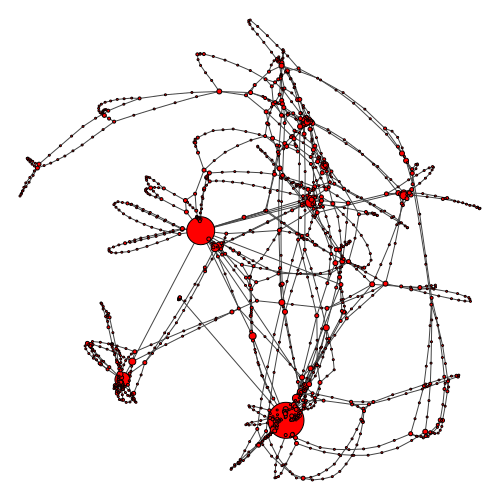

In [ ]:
graph = z.copy()
graph.to_undirected(combine_edges=dict(weight="sum"))
layout_gr = graph.layout("auto")
visual_style = {}
visual_style["vertex_size"] = z.degree()
# visual_style["vertex_label"]=z.vs['labels'] #   z.degree >= 3]
# visual_style["vertex_color"] = z.vs['id']
visual_style["layout"] = layout_gr
visual_style["edge_width"] = 1
#visual_style["edge_label"]= z.es['label']
visual_style["bbox"] = (500, 500)
ig.plot(graph,  **visual_style )


### 3.5.1 Centrality measures
For an initial overview on the centrality of nodes in the transport network, we opted for betweenness and degree as widely used measures for centrality. In general there are different approaches to calculate/measure centrality with application in transport networks, such as: criticality of nodes (Núñez and Palomares, 2014),  a combination of degree and betweenness centrality (Nie et al. 2015). Yet degree and betweenness are found to be frequent measures (Scott et al. 2006, von Ferber et al., 2009). 

**Degree centrality:** Defines the number of links associated with a node. The more links a node has, the higher its degree and hence its “central” position in the network (e.g. its importance). 

**Betweeness centrality:** The shortest path betweenness of a vertex  is defined to be the fraction of shortest paths between pairs of vertices in a network that pass through the vertex. / Betweenness counts the times that a node is passed being a “bridge” between pairs of two other nodes. As a result, a node with higher betweenness centrality represents a more important/influencing point within the network, because more transport lines and thus more connections and passengers will pass through that node. The higher a node’s betweenness, the more important they are for the efficient flow of people/connections in a transport network. 

**Eigen Centrality:**A node's influence is determined based on the amount of links it has to other nodes in the network. Eigencentrality also takes into account how well the node  is connected and how many links a node has. The advantage of eigen centrality is that nodes with influence over the whole network are identified. 

Other measures such as **closeness centrality** are not of importance to us, since we are not looking to identify the best placed transport stations in a network but focusing on the flow/throughput of the latter. Also closeness in highly connected networks have a similar score in many times, which is not useful in our case. 


### 3.5.2 Plots of degree, betweenness and eigenvector centrality

Below the plots of degree, betweenness and eigenvector centrality are displayed. 

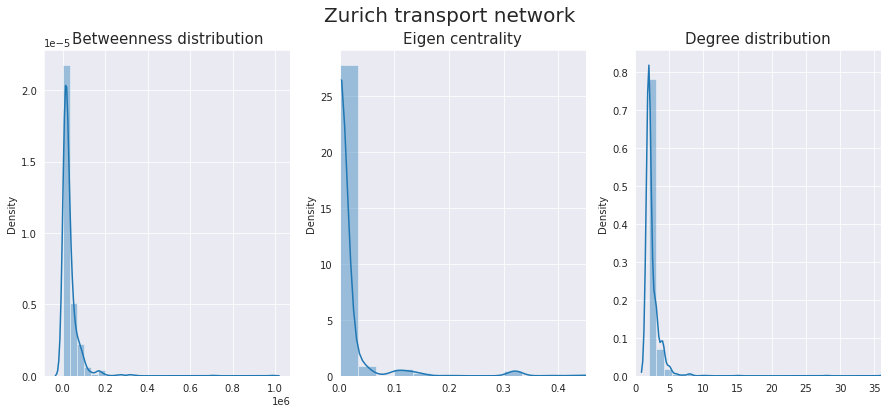

In [ ]:
btw = z.betweenness()
deg = z.degree()
eigen = z.eigenvector_centrality()
sns.set_style('darkgrid')
plt.figure(figsize=(15,6))
plt.suptitle('Zurich transport network', fontsize=20)
plt.subplot(131)
sns.distplot(btw, bins=30)
plt.ticklabel_format(axis='x', style='sci', scilimits=[0, .6])
plt.title('Betweenness distribution', fontsize=15)
plt.subplot(132)
sns.distplot(eigen, bins=30)
plt.xlim([0,0.45])
plt.title('Eigen centrality', fontsize=15)
plt.subplot(133)
sns.distplot(deg, bins=30)
plt.xlim([0,36])
plt.title('Degree distribution', fontsize=15);

**Interpretation:**

**Betweenness Plot:** Majority of betweenness values between 0.0 and 0.1. We are interested in nodes that display a betweenness close to 0.2. As mentioned earlier, a node with higher betweenness centrality represents a more important/influencing point within the network, because more transport lines and thus more connections and passengers will pass through that node.

**EigenCentrality Plot:** Majority of eigencentrality values are close to 0. We can distinguish some "outliers" with higher eigencentrality values at 0.1 and 0.3. Especially the eigencentrality values of 0.3 are of interest, since these represent more influential nodes across the whole network. 

**Degree Plot:**Majority of degrees between 0 to 5. We are interested in the few nodes that exhibit a higher degree than 3 (?). As mentioned earlier, the more links a node has, the higher its degree and hence its “central” position in the network (e.g. its importance).



Taking a closer look at the degree distribution shown below, we observe here a network, in which each node has approximately the same number of links, 2-3. This is important for the latter part of analysis.  Yet we also find that few links have a very high degree, such as 36, 28, 15 and 10. We have seen them earlier in the overall graph plot.
This indicates that we do have few linkage "extrema" with a few nodes exhibiting a lot of in- and out links versus others containing only few.

The average number of links in the underlying network is 2.49. 

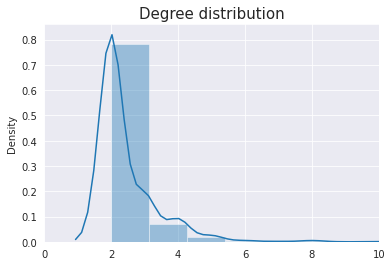

In [ ]:
sns.distplot(deg, bins=30)
plt.xlim([0,10])
plt.title('Degree distribution', fontsize=15);

In [ ]:
deg_sorted = deg.copy()
deg_sorted.sort(reverse=True)
print(deg_sorted)

mean_degree = np.mean(deg)
print(mean_degree)

[36, 28, 15, 10, 8, 8, 8, 8, 8, 8, 7, 7, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

## 3.6 Experiments

In this section we apply our targeted attacks to assess how hard it is to make the Zurich's transport system to fail. We do so by first generating design 8 random paths across the network and generate their inital shortest path - they could correspond to eight different customer itineraries. We then monitor how quickly we get to a point at which is not possible anymore to find a path between the selected node pairs.

First, to continuously assess communities in the process of node deletion and apply either the Leiden or the Louvain algorithm, the graph needs to be undirected.

In [238]:
# convert network to undirected in order to perform the Louvain/Leiden algorithm
z = ig.Graph.Read_GraphML("/content/drive/My Drive/ALSSN/zurich_glenn.graphml")
z_undirected = init_network(z)

### 3.6.1 Experiment 1: random generation of reference node pairs taken from the Touristic Substop node information

In this first experiment, we create random combinations of the touristic substops in Zurich. Such pairs will be used as start and end nodes for itineraries that we will monitor during node deletion. To investigate how these itineraries change during the process, we will monitor the shortest path changes at each iteration. 

In [239]:
# parameter setup 
n_iter = 50
n_pairs = 8
substop_path = '/content/drive/My Drive/ALSSN/touristic_substops.xlsx'

In the following step, the process of node removal is started. In each iteration, all the metrics along with the number of remaining nodes edges in the graph are recalculated. 

Iterative removal of nodes: 
In the recalculation of the remaining edges per node we can also see that a sudden drop in the number of edges during node removal points towards the fact that the deleted node must have been of high degree. 

It is expected that this removal drastically alters the network's topology (Albert et al. 2002), which we will observe as our analysis progresses. 

In [247]:
touristic_substops = pd.read_excel(substop_path)
pairs_ex1, ref_node_ids_ex1 = generate_random_pairs(n_pairs, touristic_substops['ID SUBSTOP'].to_list())
metrics_ex1 = process(z_undirected, pairs_ex1, ref_node_ids_ex1, iterations=n_iter, save_plots=True)

number of nodes: 1346, number of edges: 1657
ITER1 removed node 46016.0, number of nodes: 1345, number of edges: 1636
ITER2 removed node 46024.0, number of nodes: 1344, number of edges: 1609
ITER3 removed node 46697.0, number of nodes: 1343, number of edges: 1605
ITER4 removed node 43732.0, number of nodes: 1342, number of edges: 1601
ITER5 removed node 47217.0, number of nodes: 1341, number of edges: 1598
ITER6 removed node 45902.0, number of nodes: 1340, number of edges: 1589
ITER7 removed node 42915.0, number of nodes: 1339, number of edges: 1584
ITER8 removed node 45736.0, number of nodes: 1338, number of edges: 1571
ITER9 removed node 44487.0, number of nodes: 1337, number of edges: 1565
ITER10 removed node 45307.0, number of nodes: 1336, number of edges: 1559
ITER11 removed node 46883.0, number of nodes: 1335, number of edges: 1555
ITER12 removed node 47346.0, number of nodes: 1334, number of edges: 1552
ITER13 removed node 47032.0, number of nodes: 1333, number of edges: 1545
IT

#### Graph topology changes across iterations



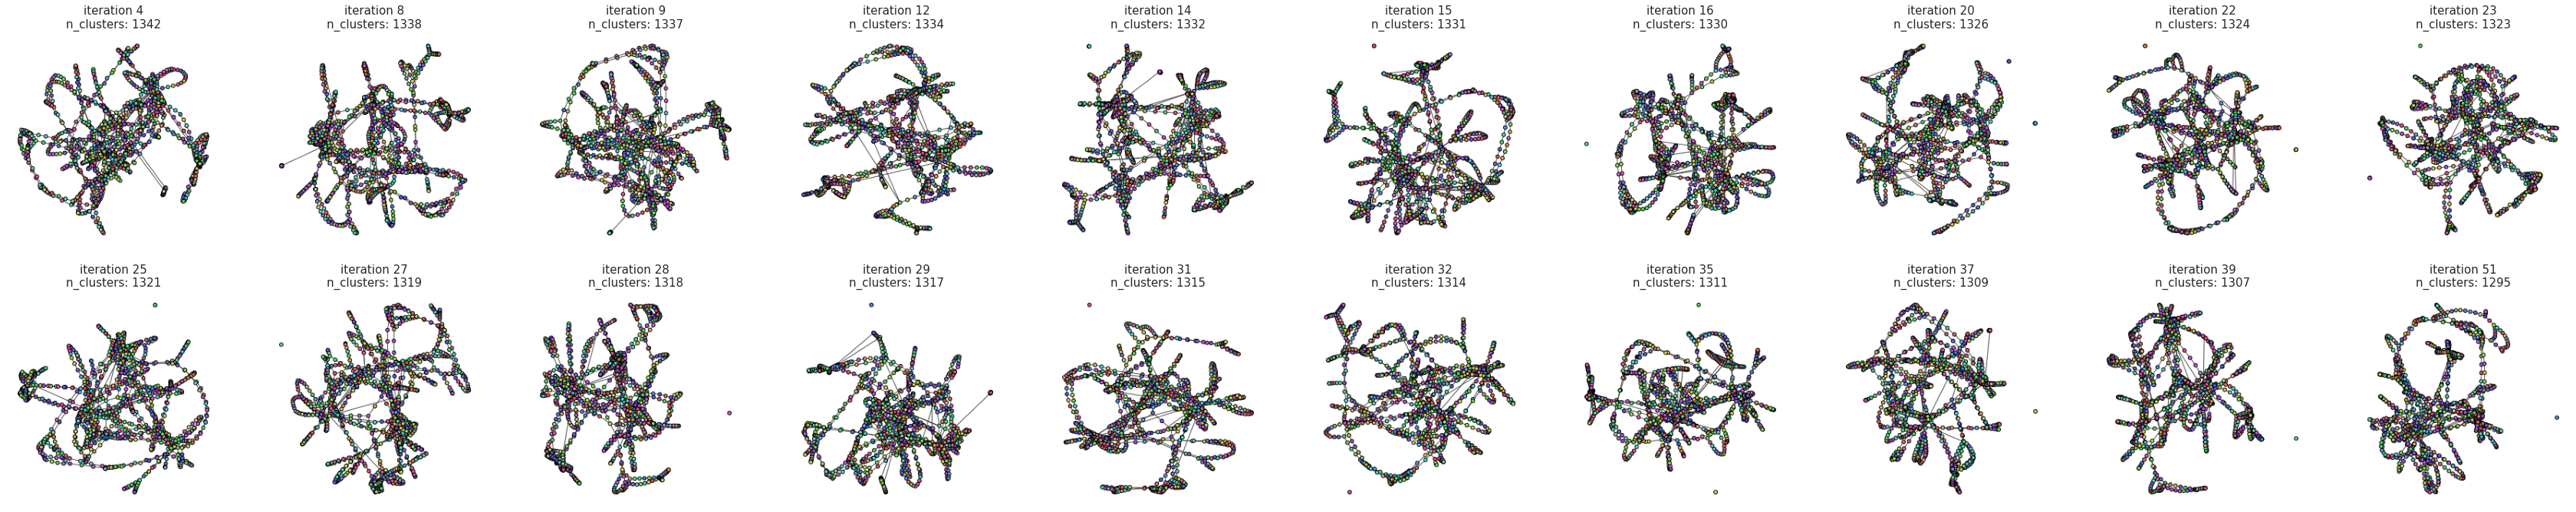

In [134]:
plt.figure(figsize=(60, 30))
plot_graphs(sample=True)

#### Shortest path changes between reference node pairs across iterations

In [ ]:
ref_graph = metrics_ex1.loc[0, 'subgraph']
for r in metrics_ex1.to_dict(orient="records"):
  shortest_path_graph(ref_graph, r['shortest_paths'], r['iteration'])

The colored points represent the itinerary of the previously calculated shortest paths across the network. Each color is associated with a different pair of reference nodes being monitored. By doing so, we can visually explore what happens to our shortest paths at each step of node deletion. 



**Visual analysis of the graphs:**

As we can see in the visualization, the elimination of connected nodes greatly changes a graph's topology. With every iteration of the node removal process, we can observe that the clusters are becoming more and more fragmented.


We see here that after **XX iterations, the shortest path marked in XX** color disappeared, as well as the path marked in XX color. 
This is due to to the fact that the itinerary between the repective start point and end point is not doable any more, hence no connection can be made between these two points. This can be due to either the start or endpoint being deleted during node removal, or due to the fact that no path connecting the two points can be found. 

After iteration 50, 50 nodes have been removed from the graph. This corresponds to 4% of the graph only. Yet with the removal of 4% of the nodes we can clearly see the fragmentation effect.


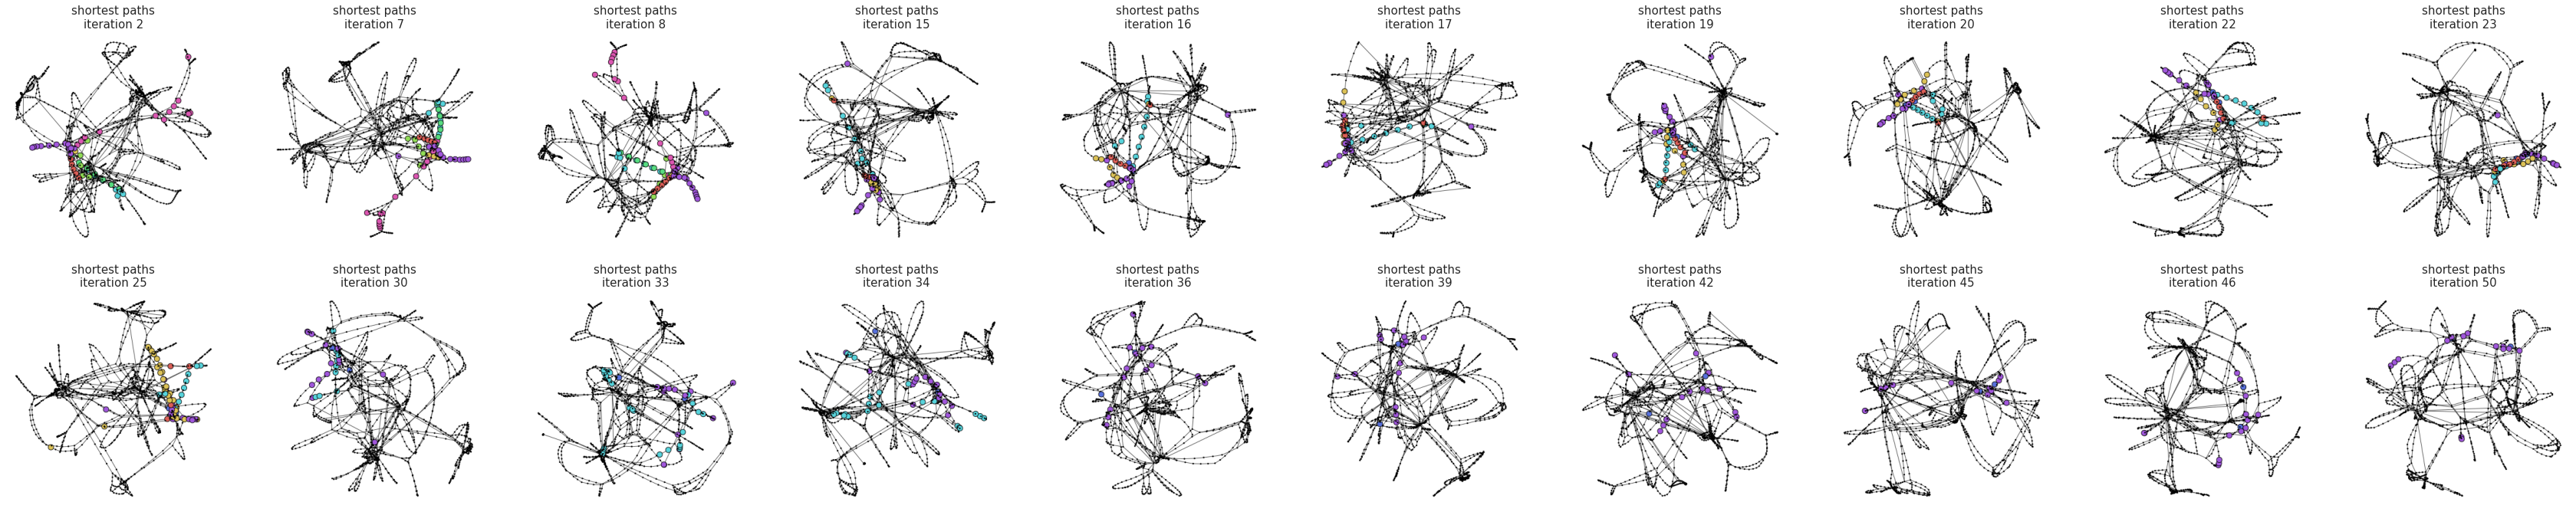

In [ ]:
plt.figure(figsize=(60, 30))
plot_shortest_paths()

### 3.6.2 Experiment 2: random generation of reference node pairs extracted from the graph
In this second experiment, we create random combinations of nodes directly picked from the whole original network. As in experiment 1, such pairs will be used as start and end nodes for which we will monitor the shortest path changes at each iteration. 

In [202]:
# parameter setup 
n_iter = 50
n_pairs = 8

Iterative removal of nodes: 

**Edges**
In the recalculation of the remaining edges per node we can also see the following:

A sudden drop in the number of edges during node removal points towards the fact that the deleted node must have been of high degree. 

It is expected that this removal drastically alters the network's topology (Albert et al. 2002), which we will observe as our analysis progresses. 

In [248]:
node_ids = [int(i) for i in z_undirected.vs["id"]]
pairs_ex2, ref_node_ids_ex2 = generate_random_pairs(n_pairs, node_ids )
metrics_ex2 = process(z_undirected, pairs_ex2, ref_node_ids_ex2, iterations=n_iter, save_plots=True)

number of nodes: 1346, number of edges: 1657
ITER1 removed node 46016.0, number of nodes: 1345, number of edges: 1636
ITER2 removed node 46024.0, number of nodes: 1344, number of edges: 1609
ITER3 removed node 46697.0, number of nodes: 1343, number of edges: 1605
ITER4 removed node 43732.0, number of nodes: 1342, number of edges: 1601
ITER5 removed node 47217.0, number of nodes: 1341, number of edges: 1598
ITER6 removed node 45902.0, number of nodes: 1340, number of edges: 1589
ITER7 removed node 42915.0, number of nodes: 1339, number of edges: 1584
ITER8 removed node 45736.0, number of nodes: 1338, number of edges: 1571
ITER9 removed node 44487.0, number of nodes: 1337, number of edges: 1565
ITER10 removed node 45307.0, number of nodes: 1336, number of edges: 1559
ITER11 removed node 46883.0, number of nodes: 1335, number of edges: 1555
ITER12 removed node 47346.0, number of nodes: 1334, number of edges: 1552
ITER13 removed node 47032.0, number of nodes: 1333, number of edges: 1545
IT

#### Graph topology changes across iterations

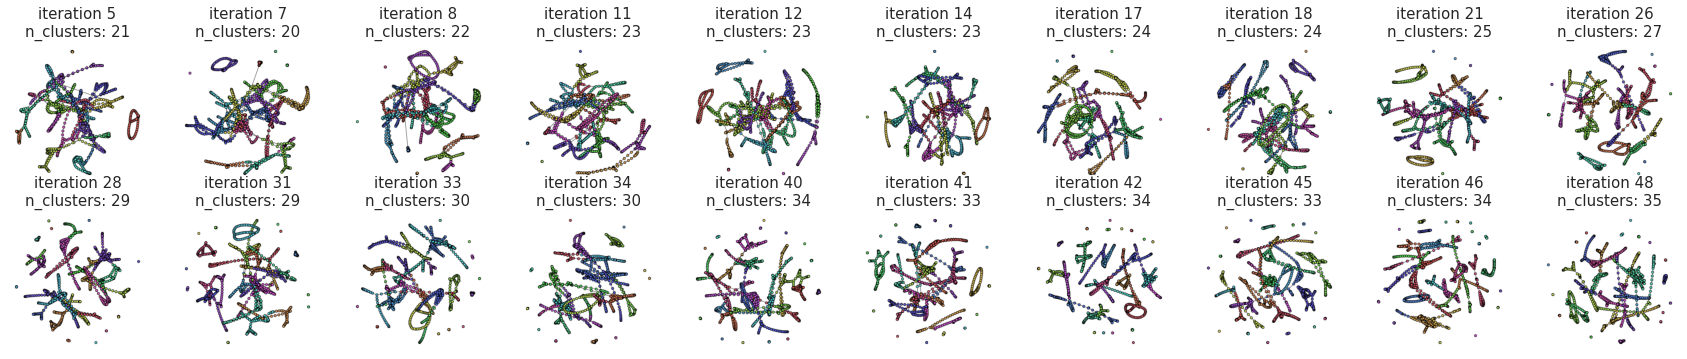

In [ ]:
plt.figure(figsize=(30, 15))
plot_graphs(sample=True)

**Visual analysis of the graphs:**

As we can see in the visualization, the elimination of connected nodes greatly changes a graph's topology. With every iteration of the node removal process, we can observe that the clusters are becoming more and more fragmented.

Application of the Leiden Algorithm: Clusters become more and more separated across iterations as expected. Yet, we cannot observe a sudden surge in the number of clusters in the initial steps of node deletion. During the process, we observe that nodes and subclusters seemingly get reassigned to other clusters: The number of clusters for example first increases in iteration 4 to 35, reaching a number of clusters at around 80-90. After that, the number of clusters decreases slightly, indicating that a node must have been deleted within a subcluster, causing the latter to be "reassigned" to another cluster.


After iteration 50, 50 nodes have been removed from the graph. This corresponds to 4% of the graph only. Yet with the removal of 4% of the nodes we can clearly see the fragmentation effect.

Fragmentation behaviour under node removal is also depending on the number of links that each node is in average connected to: The more connections, the slower the fragmentation process (Nguyen and Trang Le, 2019). In our network, the average number of links in the underlying network is 2.49. Hence we expect a rather fast fragementation process.

#### Shortest path changes between reference node pairs across iterations

In [ ]:
ref_graph = metrics_ex2.loc[0, 'subgraph']
for r in metrics_ex2.to_dict(orient="records"):
  shortest_path_graph(ref_graph, r['shortest_paths'], r['iteration'])

The colored points represent the itinerary of the previously calculated shortest paths across the network. Each color is associated with a different pair of reference nodes being monitored. By doing so, we can visually explore what happens to our shortest paths at each step of node deletion. 


**Visual analysis of the graphs:**

As we can see in the visualization, the elimination of connected nodes greatly changes a graph's topology. With every iteration of the node removal process, we can observe that the clusters are becoming more and more fragmented. 

We see here that after **XX iterations, the shortest path marked in XX** color disappeared, as well as the path marked in XX color. 
This is due to to the fact that the itinerary between the repective start point and end point is not doable any more, hence no connection can be made between these two points. This can be due to either the start or endpoint being deleted during node removal, or due to the fact that no path connecting the two points can be found. 

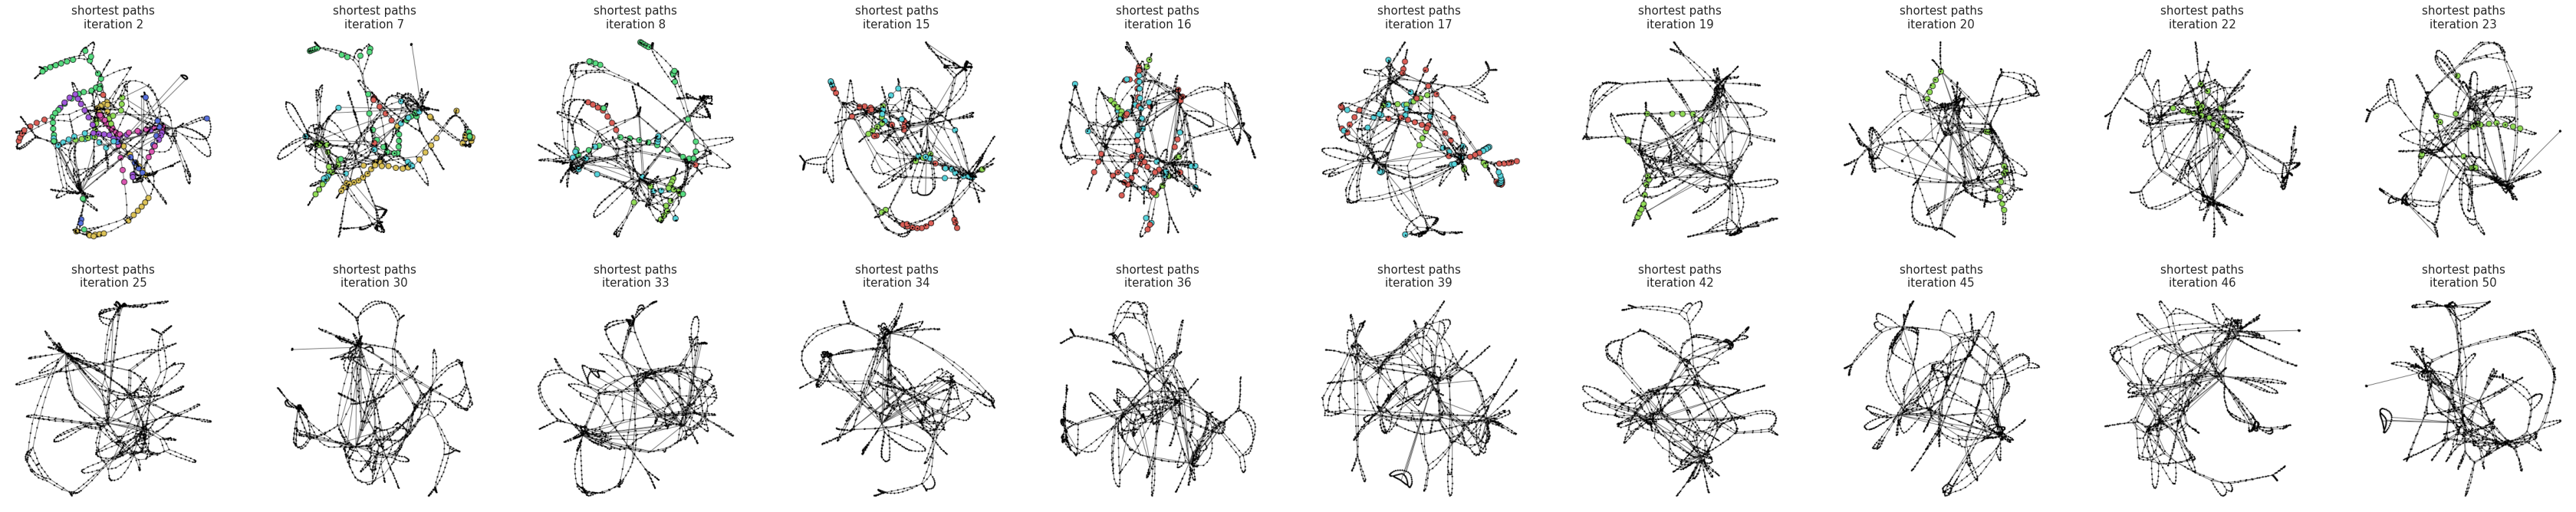

In [ ]:
plt.figure(figsize=(60, 30))
plot_shortest_paths()

## 3.7 Result Discussion

### 3.7.1 Results from experiment 1

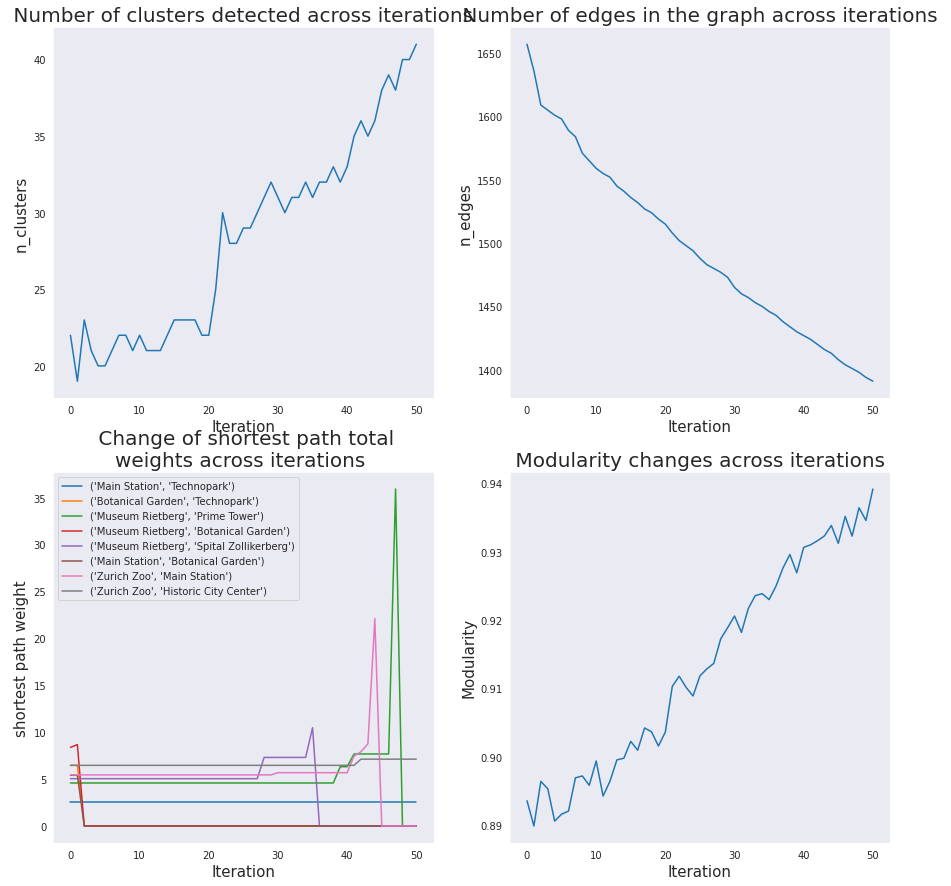

In [249]:
plt.figure(figsize=(15, 15))
plot_results(metrics_ex1, pairs_ex1, substop_path, random_ref_nodes=False)


**DISCUSSION OF RESULTS FROM EXPERIMENT 1**

**Number of clusters detected across iterations:**

For cluster building, the leiden algorithm was finally applied. We can see that the number of clusters in both approaches are somewhat similar. 

The number of clusters in experiment 1 is increasing steadily. We can observe some sudden spikes and surges in the number of clusters as more and more nodes get deleted from the network.
We can observe a drop in the number of clusters around iteration xx. 

**Number of edges in the graph across iterations:**

The number of edges in the graph across iterations is almost identical. For the number of edges in experiment 1, we can observe a sudden drop in the number of edges right at the beginning. This is due to the fact that the most central, e.g. nodes with the highest value for betweenness centrality get omitted from the network first. It is only logical that these nodes  with a high centrality value also are connected with many other nodes because more transport lines and thus more connections and passengers will pass through that node.  As a consequence their omittance causes a sharp decrease in the number of edges in the network and proves the correctness of our approach. 


**Change of shortest path total weights across iterations:**


From experiment 1 we can see the node combinations across touristic substops in Zurich. Each line represents one shortest path, e.g. one itinerary across the network. In the case of experiment 1 we are in a constrained setting, e.g. the number of substops is limited to eight touristic substops, resulting in a limited number of possible combinations of itineraries between them. 
We distinguish different behavior between these shortest paths: Some (2) of the path weights drop immediately in the first iterations, which points towards the underlying itineraries vanishing. For the weights on the remainder of the itineraries, the weights first increase sharply, before they drop close to zero thus the itinerary is deleted/not doable any more. Interestingly, the changes of the weights are occuring at the same point in time(e.g. iterations). Consequently we must assume a major change in the network **within these iterations.  ->what happens there?**


**Modularity changes:**

With regard to the changes in the modularity across iterations in experiment 1, we observe the following: The initial modularity score is at 0.86, we recognize a sharp increase in the score in the first iterations which then levels off till the end. The final modularity score is around 0.94. 


### 3.7.2 Results from experiment 2

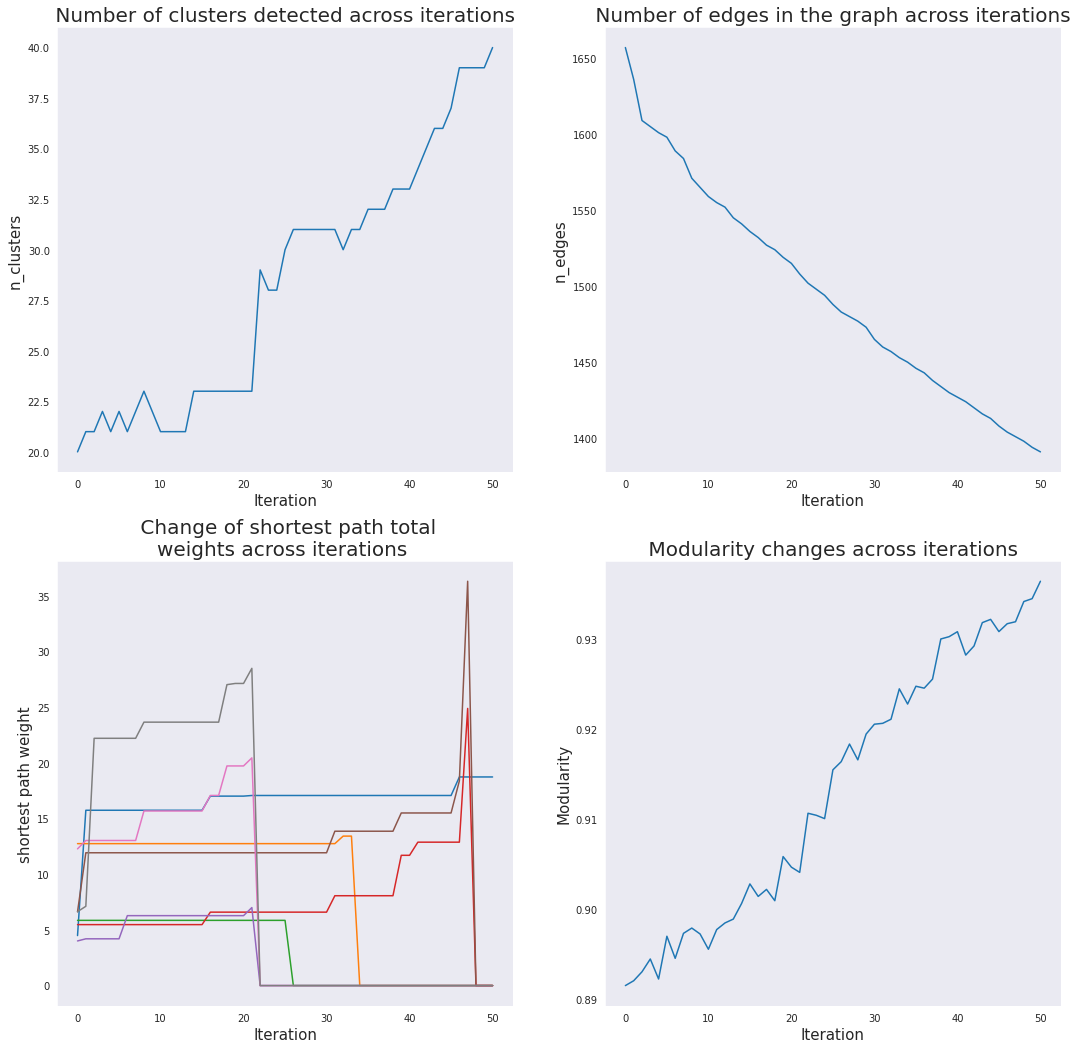

In [250]:
plt.figure(figsize=(18, 18))
plot_results(metrics_ex2, pairs_ex2, random_ref_nodes=True)

**DISCUSSION OF RESULTS EXPERIMENT 2**


**Number of clusters detected across iterations:**

The number of clusters detected during experiment 2 is increasing a bit slower than for experiment 2, yet increasing in a steady fashion as well. The oscillations in the second experiment cluster plot are somewhat higher and we see a sudden increase in clusters in iteration 30 and a sudden drop in the number of clusters in the last iterations. 


**Number of edges in the graph across iterations:**


The number of edges across iterations in experiment 2 is identical to the number of edges getting omitted during node removal as in experiment 1. We can observe a sudden drop in the number of edges right at the beginning. This is due to the fact that the most central, e.g. nodes with the highest value for betweenness centrality get omitted from the network first. 

**Change of shortest path total weights across iterations:**

From experiment 2 we can see the node combinations across touristic substops in Zurich. Each line represents one shortest path, e.g. one itinerary across the network. 
Same as in experiment one , some itinerary weights drop to 0 immediately, most likely due to the path getting erased. For the remainder of the shortest paths weights the behavior is different from before: We can distinguish “groups” of shortest paths where the weights are increasing in parallel before dropping to 0. This is interesting as it points out that there must have been a change in the underlying network that affected two of our investigated paths. Henceforth, these two shortest paths are assumed to share a part of their itinerary. 

We also can observe that there is one shortest path whose weights remain unchanged, meaning that no node from the itinerary path got deleted and no changes in the weights resulted from recalculation of shortest paths. 


**Modularity changes:** 


With regard to the changes in the modularity across iterations in experiment 2, we observe the following: The initial modularity score is at 0.86, we recognize a sharp increase in the score in the first iterations which then levels off till the end. The final modularity score is around 0.94. 

When comparing the changes in modularity across the two experiments we do not distinguish big differences in the increase of modularity across both approaches.


# 4. Conclusions


**Community detection algorithms in comparison when measured iteratively during targeted deletion:**  We have experimented both with the Louvain as well as with the Leiden algorithm and observe differences in the fragmentation process:  
 
**General results on the louvain algorithm:** In comparison to this, the louvain algorithm displayed a steady monotonic increase during further progress of node deletion. Yet we assume that one of the louvains algorithms shortcomings, arbitrarily badly connected communities, also takes place here.

**Leiden:** 
With the finally implemented Leiden algorithmus, we distinguish that the initial (and foregoing) number of nodes between both approaches depends on the sequence and degree of removed nodes but reveals similar clustering behavior across iterations. Thus ……
 
Hence, networks with high modularity are expected to have dense connections between the nodes within clusters but sparse connections between nodes in different clusters. We can observe that the level of modularity during the node removal process across both approaches is identical. An initial modularity score of 0.86 is achieved, which increases to 0.94 across iterations. This is a somewhat very acceptable score for modularity, when compared to the results of the Leiden algorithm development by Traag et al. (2019) with modularity values between 0.83 and 0.97.
 
This is in line with our expectations: When nodes are removed from a network, clusters of nodes whose links to the system disappear may be cut off (fragmented) from the main cluster. With an increased removal of nodes we expect to have more fragmented nodes in the cluster that are not connected to the main clusters any more. We expect clusters to fall apart, resulting in a sharp increase in the number of clusters and hence a decrease in the modularity score.
 
Yet, Nguyen and Trang Le (2019) found that networks with higher modularity Q have lower robustness to node removal. As a consequence, we expect that since the modularity values obtained are fairly high towards later iterations in the node removal process, the network's resistance to node removal must plummet/greatly reduce with further iterations. This has been the case in both experimental approaches: After approximately 30 iterations and 30 removed nodes, shortest paths cannot be reconstructed and the itineraries collapse. 
This is also observable in the weights: The weights of the shortest paths increase when the nodes are removed, indicating also the shortest path changes and necessarily gets longer. As a consequence, the overall weights on the shortest paths increase before the itineraries collapse. 


**With regard to the resistance of the network we can conclude the following:**
The shortest paths in the “artificial” itineraries of experiment 1 seem to be more robust to node removal but the overall behavior stays the same. This lets us conclude that, with exception for weights, the selection of shortest paths in a confined or a random manner does not matter much, 
The network does not exhibit great resistance to node removal “attacks” since we see the first paths get erased from the network within the first iterations.
Modularity is similar across approaches and our results are in line with the findings of Nguyen and Trang Le (2019) who found that networks with a higher modularity score have a lower robustness. 


# 5. Sources


A. Háznagy, I. Fi, A. London and T. Nemeth, "Complex network analysis of public transportation networks: A comprehensive study," 2015 International Conference on Models and Technologies for Intelligent Transportation Systems (MT-ITS), 2015, pp. 371-378, doi: 10.1109/MTITS.2015.7223282.

Nuñez, E., & Palomares, J.J. (2014). Measuring the vulnerability of public transport networks.

Scott, D. M., Novak, D. C., Aultman-Hall, L. and Guo, F. (2006) Network robustness index: A new method for identifying critical links and evaluating the performance of transportation networks. Journal of Transport Geography 14, 215–227. 

von Ferber, C., Holovatch. T., Holovatch, Y. and Palchykov V. (2009) Public transport networks: empirical analysis and modeling. The European Physical Journal B 68, 261-275 

Albert, R., Jeong, H. & Barabási, AL. Error and attack tolerance of complex networks. Nature 406, 378–382 (2000). https://doi.org/10.1038/35019019

Holme P, Kim BJ, Yoon CN, Han SK. Attack vulnerability of complex networks. Phys Rev E Stat Nonlin Soft Matter Phys. 2002 May;65(5 Pt 2):056109. doi: 10.1103/PhysRevE.65.056109. Epub 2002 May 7. PMID: 12059649.

Nie, T., Guo, Z., Zhao, K., & Lu, Z. (2015). New attack strategies for complex networks. Physica A-statistical Mechanics and Its Applications, 424, 248-253.

Traag, V.A., Waltman, L. & van Eck, N.J. From Louvain to Leiden: guaranteeing well-connected communities. Sci Rep 9, 5233 (2019). https://doi.org/10.1038/s41598-019-41695-z

Nguyen Q, Pham HD, Cassi D, Bellingeri M (2019) Conditional attack strategy for real-world complex networks. Physica A 530:121561
